In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import os
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import json
import pandas as pd
import re

from sklearn.metrics import confusion_matrix
from ml_genn import Network, Population, Connection
from ml_genn.callbacks import SpikeRecorder, VarRecorder
from ml_genn.compilers import InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.synapses import Exponential

from ml_genn.utils.data import calc_latest_spike_time
from ml_genn.compilers.event_prop_compiler import default_params

from ml_genn.utils.data import (calc_latest_spike_time, calc_max_spikes,
                                preprocess_tonic_spikes)

from rawHD_dataset_loader_padded_spikes import rawHD_Loader

In [3]:
# sample ID used for visual
sample_id = 0

In [4]:
# loading parameter values from last successful run
# param_dir = "output/rawHD_chapter_write_up_cross_validation/params.json"
param_dir = "rawHD_params.json"

with open(param_dir, "r") as f:
        params = json.load(f) 

params["num_samples"] = None
params["BATCH_SIZE"] = 64
params["recurrent"] = True
params["weights_dir"] = "/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/testing_cross_validation_delete_4/"

In [5]:
params["DT_MS"] = 1.0
params["TAU_MEM"] = 20.0
params["TAU_SYN"] = 5.0
params["num_samples"] = None
params["sample_id"] = 0     #sample used for graph generation (starting at 0, < num_samples)
params["return_single_sample"] = None

#params["weights_dir"] = "rawHD_pretrained_weights_recurrent"
params["bit"] = 8
params["timesteps"] = 2000

params["output_dir"] = "rawHD_genn_inference"

params["neuron_dislay_id"] = 300

# toggle to record spikes, useful for debugging, but memory intensive
params["record_network_ih_activity"] =  True

In [6]:
x_train, y_train, z_train, x_test, y_test, z_test, x_validation, y_validation, z_validation = rawHD_Loader(dir = os.getcwd() + params["dataset_directory"],
                                                                                                           num_samples=params["num_samples"],
                                                                                                           shuffle = True,
                                                                                                           shuffle_seed = 0,
                                                                                                           process_padded_spikes = False)


In [7]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

#x_test = np.load("spiking-google-speech-commands/testing_x_spikes.npy", allow_pickle=True)
#y_test = np.load("spiking-google-speech-commands/testing_y_spikes.npy", allow_pickle=True)

# Preprocess
x_train_spikes = []
for i in range(len(x_train)):
    events = x_train[i]
    x_train_spikes.append(preprocess_tonic_spikes(events, 
                                                  x_train[0].dtype.names,
                                                  (params["NUM_INPUT"], 1, 1),
                                                  time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_train_spikes)
latest_spike_time = calc_latest_spike_time(x_train_spikes)
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

# Preprocess
x_test_spikes = [] # change to training, to have two plots; one for test and one for training
for i in range(len(x_test)):
    events = x_test[i]
    x_test_spikes.append(preprocess_tonic_spikes(events, 
                                                  x_test[0].dtype.names,
                                                  (params["NUM_INPUT"], 1, 1),
                                                  time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_test_spikes)
latest_spike_time = calc_latest_spike_time(x_test_spikes)
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
Max spikes 2386, latest spike time 1599
Max spikes 2190, latest spike time 1599


In [8]:
train_files, validation_files = [], []
for f in os.listdir(params["weights_dir"]):
    if f.startswith("train_output"):
        train_files.append(f)
    if f.startswith("validation_output"):
        validation_files.append(f)

assert len(train_files) == len(validation_files), "mismatch of val to train output"

train_accuracy = {}
for file in train_files:
    df = pd.read_csv(params["weights_dir"] + file)
    train_accuracy[int(re.split(r'[_\.]', file)[2])] = df["accuracy"]

validation_accuracy = {}
for file in validation_files:
    df = pd.read_csv(params["weights_dir"] + file)
    validation_accuracy[int(re.split(r'[_\.]', file)[2])] = df["accuracy"]

speaker = list(dict(sorted(train_accuracy.items())).keys())
#training = list(dict(sorted(train_accuracy.items())).values())
#validation = list(dict(sorted(validation_accuracy.items())).values())

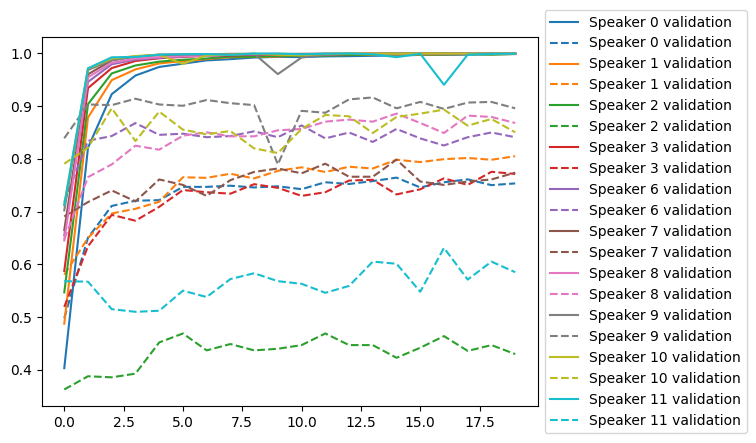

In [9]:
for count, s in enumerate(speaker):
    plt.plot(list(train_accuracy[s]), 
             c = f"C{count}",
             label = f"Speaker {s} validation")
    
    plt.plot(list(validation_accuracy[s]), 
             linestyle = 'dashed',
             c = f"C{count}",
             label = f"Speaker {s} validation")
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
# change directory for output code of (ML_)GeNN
try:
    os.makedirs("output/" + params["output_dir"] + "_inference_run")
except:
    pass

os.chdir("output/" + params["output_dir"] + "_inference_run")

In [11]:
accuracy_train_list = []
predict_train_list = []

for speaker in np.unique(z_train):
    print(f" ! Running Inference for Serialiser {speaker} !")

    if speaker not in z_train:
        accuracy_train_list.append(0)
        # redundant as only training-speakers will be found.
        print("! Skipping speaker as this is not found within test data !")
        continue
    
    # loading pretrained weights
    w_i2h = np.load(f"{params['weights_dir']}serialiser_{speaker}/{params['NUM_EPOCH'] - 1}-Conn_Pop0_Pop1-g.npy", allow_pickle = True)
    w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                        params["NUM_HIDDEN"]))

    if params["recurrent"]:
        w_h2h = np.load(f"{params['weights_dir']}serialiser_{speaker}/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop1-g.npy", allow_pickle = True)
        w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                            params["NUM_HIDDEN"]))

    w_h2o = np.load(f"{params['weights_dir']}serialiser_{speaker}/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop2-g.npy", allow_pickle = True)
    w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                        params["NUM_OUTPUT"]))
    
    network = Network(default_params)

    with network:
        # Populations
        input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                        params["NUM_INPUT"],
                        record_spikes=True)
        
        hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                        tau_mem=20.0),
                    params.get("NUM_HIDDEN"), 
                    record_spikes=True)
        
        output = Population(LeakyIntegrate(tau_mem=20.0, 
                                    readout="avg_var_exp_weight"),
                    params.get("NUM_OUTPUT"), 
                    record_spikes=True)

        Connection(input, hidden, Dense(weight = w_i2h),
                    Exponential(5.0))
        
        if params.get("recurrent"):
            Connection(hidden, hidden, Dense(weight = w_h2h),
                    Exponential(5.0))
        
        Connection(hidden, output, Dense(w_h2o),
                    Exponential(5.0))

    compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                                reset_in_syn_between_batches=True,
                                #quantise_num_weight_bits=8,
                                #quantise_weight_percentile=99,
                                batch_size = params.get("BATCH_SIZE"))

    compiled_net = compiler.compile(network)


    with compiled_net:

        callbacks = ["batch_progress_bar",
                    SpikeRecorder(input, 
                                key = "input_spikes",
                                example_filter = sample_id),
                    SpikeRecorder(hidden,
                                key = "hidden_spikes",
                                example_filter = sample_id),
                    VarRecorder(hidden, 
                                var = "v",
                                key = "hidden_voltages",
                                example_filter = sample_id),
                    VarRecorder(output, 
                                var = "v",
                                key = "output_voltages",
                                example_filter = sample_id)]
        
        
        e_metrics, e_cb_data = compiled_net.evaluate({input: x_train_spikes}, {output: y_train}, callbacks = callbacks)
        
        metrics, cb_data = compiled_net.predict({input: x_train_spikes}, output, callbacks = callbacks)

        #compiled_net.save(("quant8",), serialiser)


        print(f"Accuracy = {100 * e_metrics[output].result}%")
        
        accuracy_train_list.append(100 * e_metrics[output].result)
        predict_train_list.append(metrics[output])

 ! Running Inference for Serialiser 0 !


/its/home/ts468/PhD/ve/genn_5_1_0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Nothing to be done for 'all'.
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 68.81it/s]


Accuracy = 94.78927203065133%
 ! Running Inference for Serialiser 1 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 69.53it/s]


Accuracy = 98.6360153256705%
 ! Running Inference for Serialiser 2 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 69.47it/s]


Accuracy = 98.94252873563218%
 ! Running Inference for Serialiser 3 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 69.32it/s]


Accuracy = 98.6360153256705%
 ! Running Inference for Serialiser 6 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 69.20it/s]


Accuracy = 97.80842911877394%
 ! Running Inference for Serialiser 7 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 69.19it/s]


Accuracy = 99.17241379310346%
 ! Running Inference for Serialiser 8 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 69.17it/s]


Accuracy = 97.9463601532567%
 ! Running Inference for Serialiser 9 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 70.41it/s]


Accuracy = 93.16475095785441%
 ! Running Inference for Serialiser 10 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 68.34it/s]


Accuracy = 97.80842911877394%
 ! Running Inference for Serialiser 11 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 70.16it/s]

Accuracy = 96.99616858237547%


In [12]:
accuracy_test_list = []
predict_test_list = []

for speaker in np.unique(z_train):
    print(f" ! Running Inference for Serialiser {speaker} !")
    
    # loading pretrained weights
    w_i2h = np.load(params["weights_dir"] + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop0_Pop1-g.npy", allow_pickle = True)
    w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                        params["NUM_HIDDEN"]))

    if params["recurrent"]:
        w_h2h = np.load(params["weights_dir"] + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop1-g.npy", allow_pickle = True)
        w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                            params["NUM_HIDDEN"]))

    w_h2o = np.load(params["weights_dir"] + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop2-g.npy", allow_pickle = True)
    w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                        params["NUM_OUTPUT"]))
    
    network = Network(default_params)

    with network:
        # Populations
        input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                        params["NUM_INPUT"],
                        record_spikes=True)
        
        hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                        tau_mem=20.0),
                    params.get("NUM_HIDDEN"), 
                    record_spikes=True)
        
        output = Population(LeakyIntegrate(tau_mem=20.0, 
                                    readout="avg_var_exp_weight"),
                    params.get("NUM_OUTPUT"), 
                    record_spikes=True)

        Connection(input, hidden, Dense(weight = w_i2h),
                    Exponential(5.0))
        
        if params.get("recurrent"):
            Connection(hidden, hidden, Dense(weight = w_h2h),
                    Exponential(5.0))
        
        Connection(hidden, output, Dense(w_h2o),
                    Exponential(5.0))

    compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                                reset_in_syn_between_batches=True,
                                #quantise_num_weight_bits=8,
                                #quantise_weight_percentile=99,
                                batch_size = params.get("BATCH_SIZE"))

    compiled_net = compiler.compile(network)


    with compiled_net:

        callbacks = ["batch_progress_bar",
                    SpikeRecorder(input, 
                                key = "input_spikes",
                                example_filter = sample_id),
                    SpikeRecorder(hidden,
                                key = "hidden_spikes",
                                example_filter = sample_id),
                    VarRecorder(hidden, 
                                var = "v",
                                key = "hidden_voltages",
                                example_filter = sample_id),
                    VarRecorder(output, 
                                var = "v",
                                key = "output_voltages",
                                example_filter = sample_id)]
        
        
        e_metrics, e_cb_data = compiled_net.evaluate({input: x_test_spikes}, {output: y_test}, callbacks = callbacks)
        
        metrics, cb_data = compiled_net.predict({input: x_test_spikes}, output, callbacks = callbacks)

        #compiled_net.save(("quant8",), serialiser)


        print(f"Accuracy = {100 * e_metrics[output].result}%")
        
        accuracy_test_list.append(100 * e_metrics[output].result)
        predict_test_list.append(metrics[output])

 ! Running Inference for Serialiser 0 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 64.44it/s]


Accuracy = 85.20318021201413%
 ! Running Inference for Serialiser 1 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 63.29it/s]


Accuracy = 86.13074204946997%
 ! Running Inference for Serialiser 2 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 63.02it/s]


Accuracy = 88.42756183745583%
 ! Running Inference for Serialiser 3 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 62.34it/s]


Accuracy = 90.59187279151944%
 ! Running Inference for Serialiser 6 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 62.73it/s]


Accuracy = 87.23498233215548%
 ! Running Inference for Serialiser 7 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 63.73it/s]


Accuracy = 89.2226148409894%
 ! Running Inference for Serialiser 8 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 62.40it/s]


Accuracy = 85.1148409893993%
 ! Running Inference for Serialiser 9 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 62.28it/s]


Accuracy = 87.94169611307422%
 ! Running Inference for Serialiser 10 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 62.14it/s]


Accuracy = 86.83745583038869%
 ! Running Inference for Serialiser 11 !
make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.87it/s]

Accuracy = 86.17491166077738%


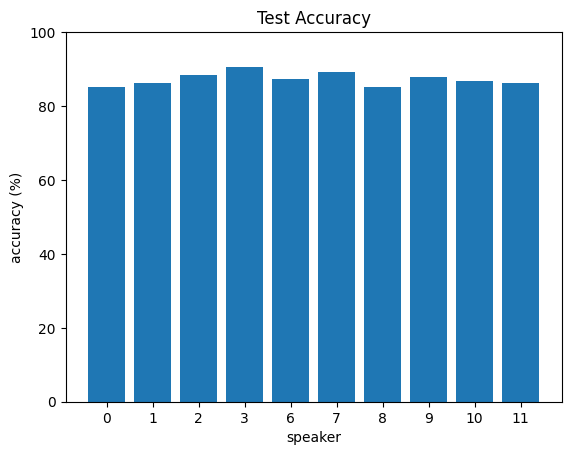

In [13]:
plt.bar(list(range(10)), accuracy_test_list)

plt.ylim(0, 100)
plt.ylabel("accuracy (%)")
plt.xlabel("speaker")
plt.xticks(list(range(10)), np.unique(z_train))
plt.title("Test Accuracy")
plt.show()

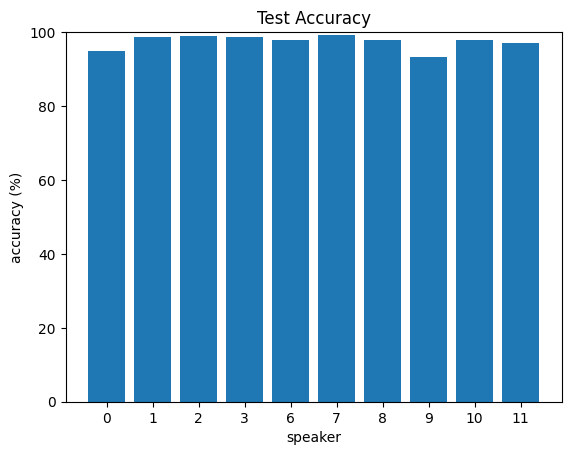

In [14]:
plt.bar(list(range(10)), accuracy_train_list)

plt.ylim(0, 100)
plt.ylabel("accuracy (%)")
plt.xlabel("speaker")
plt.xticks(list(range(10)), np.unique(z_train))
plt.title("Test Accuracy")
plt.show()

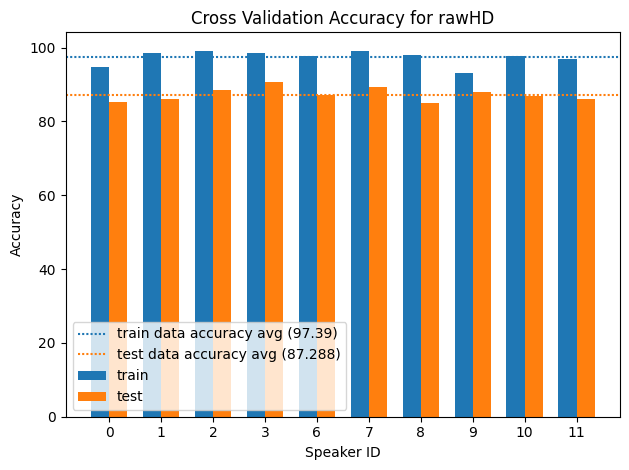

In [15]:
x = np.arange(len(np.unique(z_train)))
width = 0.35

plt.bar(x - width/2, accuracy_train_list, width, label='train')
plt.bar(x + width/2, accuracy_test_list, width, label='test')

plt.xlabel('Speaker ID')
plt.ylabel('Accuracy')
plt.title('Cross Validation Accuracy for rawHD')
plt.xticks(x, np.unique(z_train))

plt.axhline(sum(accuracy_train_list) / len(accuracy_train_list), color = "C0", linestyle = (2, (1, 1)), label = f"train data accuracy avg ({np.round(sum(accuracy_train_list) / len(accuracy_train_list), 4)})")
plt.axhline(sum(accuracy_test_list) / len(accuracy_test_list), color = "C1", linestyle = (2, (1, 1)), label = f"test data accuracy avg ({np.round(sum(accuracy_test_list) / len(accuracy_test_list), 4)})")

plt.tight_layout()
plt.legend()
plt.show()

# TODO: Train (Train + Validation) should be unseen validation

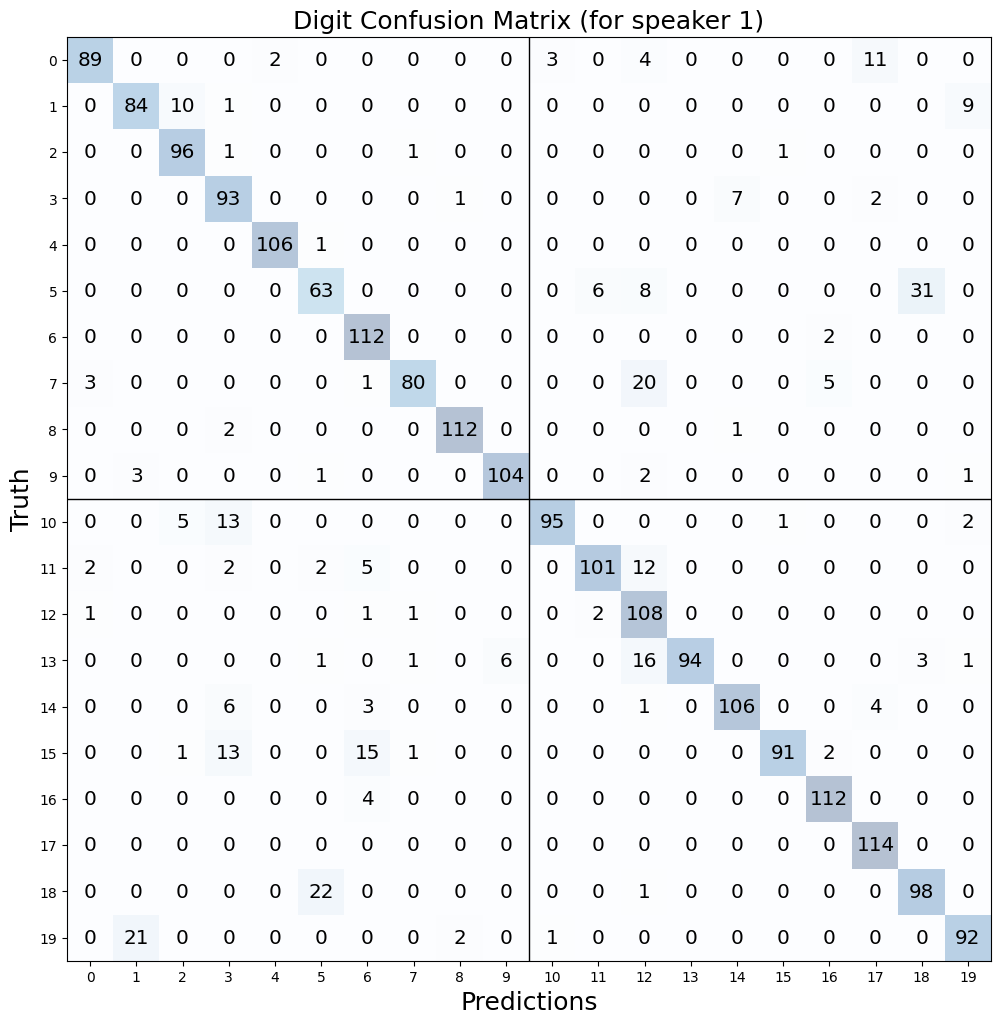

In [16]:
speaker_index = 1
cm = confusion_matrix(y_test, np.argmax(predict_test_list[speaker_index], 1))
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

# Move x-axis labels to bottom
ax.xaxis.set_ticks_position('bottom')
mid = cm.shape[0] / 2
ax.axhline(mid - 0.5, linewidth=1, c = "k")
ax.axvline(mid - 0.5, linewidth=1, c = "k")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='x-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title(f'Digit Confusion Matrix (for speaker {speaker_index})', fontsize=18)
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.show()

## list all Confusion matrix

In [25]:
speaker_index = 1
for speaker in range(len(np.unique(z_train))):
    continue
    cm = confusion_matrix(y_test, np.argmax(predict_test_list[speaker], 1))
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

    # Move x-axis labels to bottom
    ax.xaxis.set_ticks_position('bottom')
    mid = cm.shape[0] / 2
    ax.axhline(mid - 0.5, linewidth=1, c = "k")
    ax.axvline(mid - 0.5, linewidth=1, c = "k")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Truth', fontsize=18)
    plt.title(f'Digit Confusion Matrix (for speaker {np.unique(z_train)[speaker]})', fontsize=18)
    plt.xticks(list(range(20)))
    plt.yticks(list(range(20)))
    plt.show()

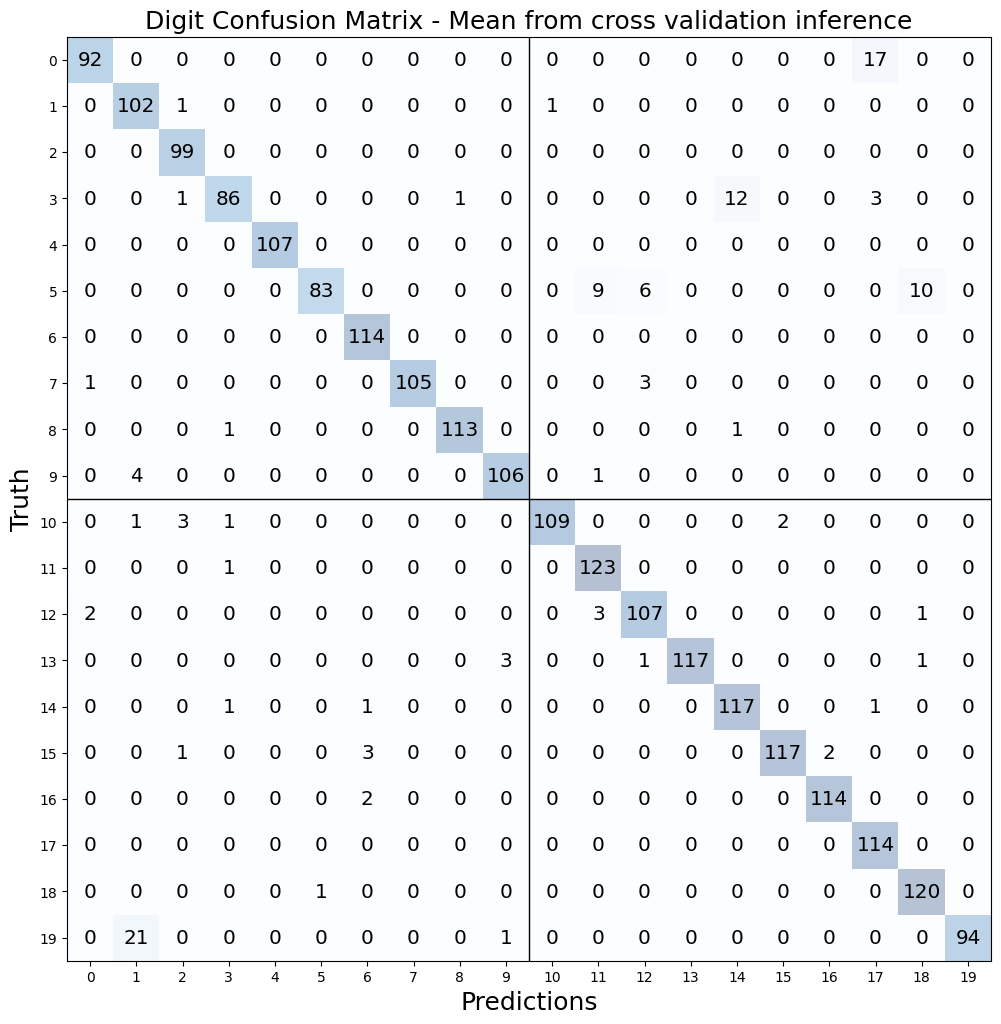

In [18]:
cm = confusion_matrix(y_test, np.argmax((np.sum(predict_test_list, 0)), 1))
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

# Move x-axis labels to bottom
ax.xaxis.set_ticks_position('bottom')
mid = cm.shape[0] / 2
ax.axhline(mid - 0.5, linewidth=1, c = "k")
ax.axvline(mid - 0.5, linewidth=1, c = "k")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='x-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title('Digit Confusion Matrix - Mean from cross validation inference', fontsize=18)
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.show()

# single inference run

In [19]:
single_accuracy_test_list = []
single_predict_test_list = []

# loading pretrained weights
w_i2h = np.load(params["weights_dir"] + f"serialiser_all" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop0_Pop1-g.npy", allow_pickle = True)
w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                    params["NUM_HIDDEN"]))

if params["recurrent"]:
    w_h2h = np.load(params["weights_dir"] + f"serialiser_all" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop1-g.npy", allow_pickle = True)
    w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                        params["NUM_HIDDEN"]))

w_h2o = np.load(params["weights_dir"] + f"serialiser_all" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop2-g.npy", allow_pickle = True)
w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                    params["NUM_OUTPUT"]))

network = Network(default_params)

with network:
    # Populations
    input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                    params["NUM_INPUT"],
                    record_spikes=True)
    
    hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                    tau_mem=20.0),
                params.get("NUM_HIDDEN"), 
                record_spikes=True)
    
    output = Population(LeakyIntegrate(tau_mem=20.0, 
                                readout="avg_var_exp_weight"),
                params.get("NUM_OUTPUT"), 
                record_spikes=True)

    Connection(input, hidden, Dense(weight = w_i2h),
                Exponential(5.0))
    
    if params.get("recurrent"):
        Connection(hidden, hidden, Dense(weight = w_h2h),
                Exponential(5.0))
    
    Connection(hidden, output, Dense(w_h2o),
                Exponential(5.0))

compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                            reset_in_syn_between_batches=True,
                            #quantise_num_weight_bits=8,
                            #quantise_weight_percentile=99,
                            batch_size = params.get("BATCH_SIZE"))

compiled_net = compiler.compile(network)


with compiled_net:

    callbacks = ["batch_progress_bar",
                SpikeRecorder(input, 
                            key = "input_spikes",
                            example_filter = sample_id),
                SpikeRecorder(hidden,
                            key = "hidden_spikes",
                            example_filter = sample_id),
                VarRecorder(hidden, 
                            var = "v",
                            key = "hidden_voltages",
                            example_filter = sample_id),
                VarRecorder(output, 
                            var = "v",
                            key = "output_voltages",
                            example_filter = sample_id)]
    
    
    e_metrics, e_cb_data = compiled_net.evaluate({input: x_test_spikes}, {output: y_test}, callbacks = callbacks)
    
    metrics, cb_data = compiled_net.predict({input: x_test_spikes}, output, callbacks = callbacks)

    #compiled_net.save(("quant8",), serialiser)


    print(f"Accuracy = {100 * e_metrics[output].result}%")
    
    single_accuracy_test = 100 * e_metrics[output].result
    single_predict_test = metrics[output]

make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 36/36 [00:00<00:00, 61.66it/s]

Accuracy = 85.07067137809187%


Digit Confusion Matrix run across all speakers using the test dataset


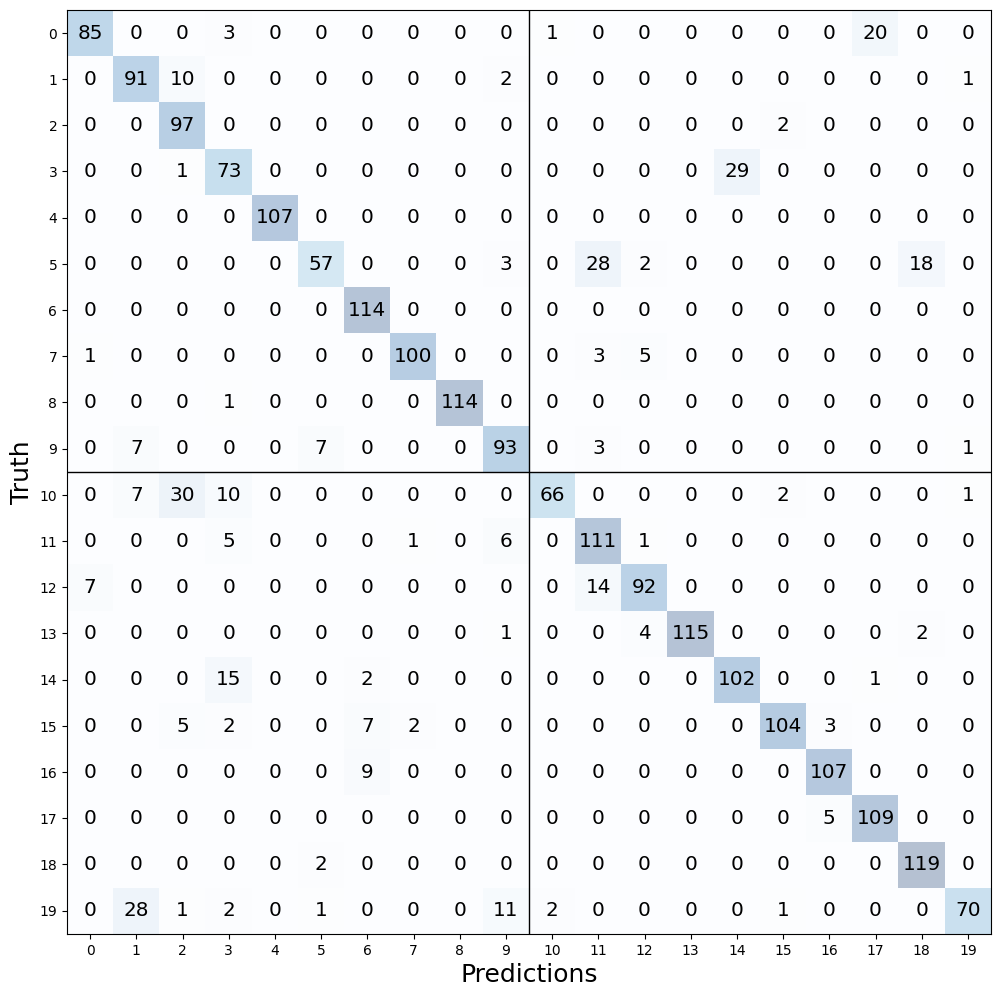

In [20]:
cm = confusion_matrix(y_test, np.argmax(single_predict_test, 1))
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

# Move x-axis labels to bottom
ax.xaxis.set_ticks_position('bottom')
mid = cm.shape[0] / 2
ax.axhline(mid - 0.5, linewidth=1, c = "k")
ax.axvline(mid - 0.5, linewidth=1, c = "k")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='x-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
#plt.title(f'Digit Confusion Matrix run across all speakers', fontsize=18)
print("Digit Confusion Matrix run across all speakers using the test dataset")
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.show()

## Training

In [21]:
single_accuracy_train_list = []
single_predict_train_list = []

# loading pretrained weights
w_i2h = np.load(params["weights_dir"] + f"serialiser_all" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop0_Pop1-g.npy", allow_pickle = True)
w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                    params["NUM_HIDDEN"]))

if params["recurrent"]:
    w_h2h = np.load(params["weights_dir"] + f"serialiser_all" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop1-g.npy", allow_pickle = True)
    w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                        params["NUM_HIDDEN"]))

w_h2o = np.load(params["weights_dir"] + f"serialiser_all" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop2-g.npy", allow_pickle = True)
w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                    params["NUM_OUTPUT"]))

network = Network(default_params)

with network:
    # Populations
    input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                    params["NUM_INPUT"],
                    record_spikes=True)
    
    hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                    tau_mem=20.0),
                params.get("NUM_HIDDEN"), 
                record_spikes=True)
    
    output = Population(LeakyIntegrate(tau_mem=20.0, 
                                readout="avg_var_exp_weight"),
                params.get("NUM_OUTPUT"), 
                record_spikes=True)

    Connection(input, hidden, Dense(weight = w_i2h),
                Exponential(5.0))
    
    if params.get("recurrent"):
        Connection(hidden, hidden, Dense(weight = w_h2h),
                Exponential(5.0))
    
    Connection(hidden, output, Dense(w_h2o),
                Exponential(5.0))

compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                            reset_in_syn_between_batches=True,
                            #quantise_num_weight_bits=8,
                            #quantise_weight_percentile=99,
                            batch_size = params.get("BATCH_SIZE"))

compiled_net = compiler.compile(network)


with compiled_net:

    callbacks = ["batch_progress_bar",
                SpikeRecorder(input, 
                            key = "input_spikes",
                            example_filter = sample_id),
                SpikeRecorder(hidden,
                            key = "hidden_spikes",
                            example_filter = sample_id),
                VarRecorder(hidden, 
                            var = "v",
                            key = "hidden_voltages",
                            example_filter = sample_id),
                VarRecorder(output, 
                            var = "v",
                            key = "output_voltages",
                            example_filter = sample_id)]
    
    
    e_metrics, e_cb_data = compiled_net.evaluate({input: x_train_spikes}, {output: y_train}, callbacks = callbacks)
    
    metrics, cb_data = compiled_net.predict({input: x_train_spikes}, output, callbacks = callbacks)

    #compiled_net.save(("quant8",), serialiser)


    print(f"Accuracy = {100 * e_metrics[output].result}%")
    
    single_accuracy_train = 100 * e_metrics[output].result
    single_predict_train = metrics[output]

make: Entering directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/temp/Intel-Neuromorphic-Research-Project/output/rawHD_genn_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 102/102 [00:01<00:00, 68.05it/s]

Accuracy = 99.87739463601532%


Digit Confusion Matrix run across all speakers


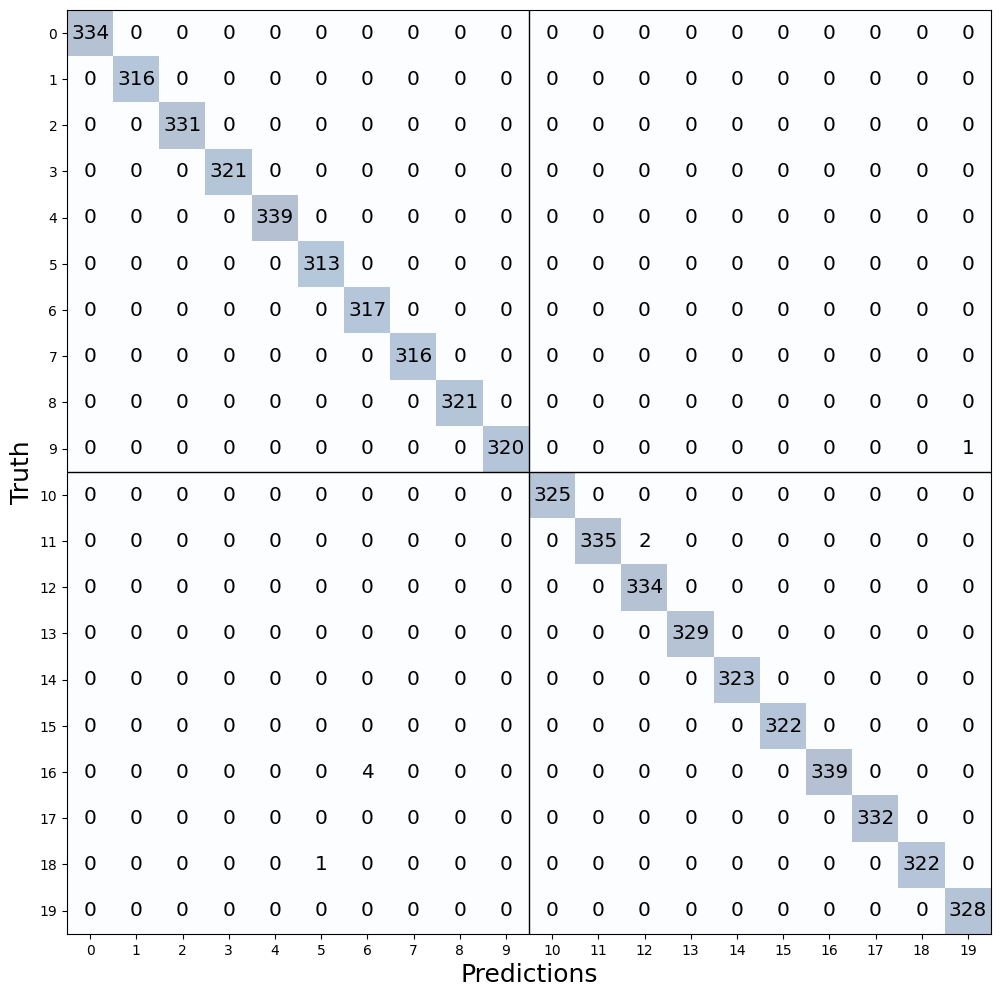

In [22]:
cm = confusion_matrix(y_train, np.argmax(single_predict_train, 1))
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

# Move x-axis labels to bottom
ax.xaxis.set_ticks_position('bottom')
mid = cm.shape[0] / 2
ax.axhline(mid - 0.5, linewidth=1, c = "k")
ax.axvline(mid - 0.5, linewidth=1, c = "k")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='x-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
#plt.title(f'Digit Confusion Matrix run across all speakers', fontsize=18)
print("Digit Confusion Matrix run across all speakers")
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.show()

# Delete

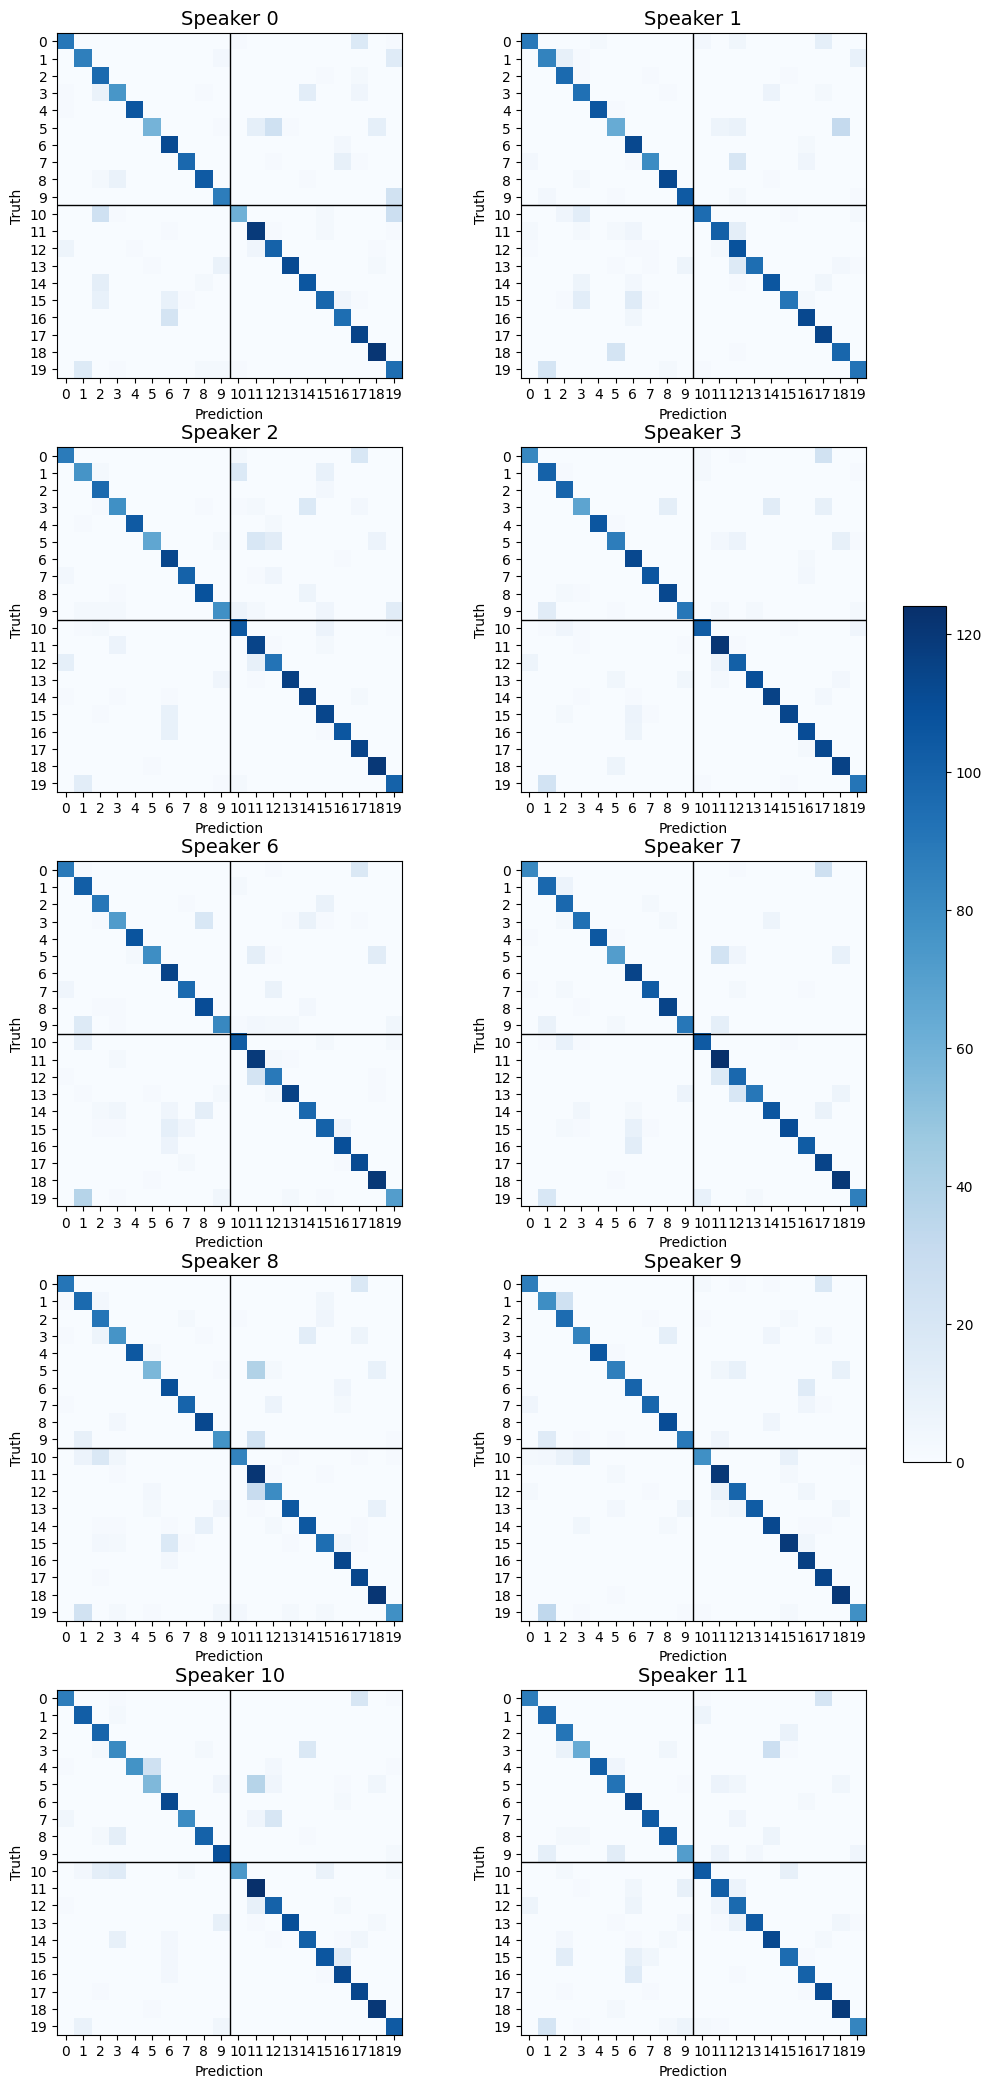

In [23]:
speakers = np.unique(z_train)
num_speakers = len(speakers)

cm_list = []
for idx, spk in enumerate(speakers):
    preds = np.argmax(predict_test_list[idx], axis=1)
    cm = confusion_matrix(y_test, preds)
    cm_list.append(cm)

cm_arr = np.stack(cm_list)
vmax = cm_arr.max()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize = (12, 26))
for count, ax in enumerate(axes.flat):
    im = ax.imshow(cm_arr[count], cmap='Blues', vmin=0, vmax=vmax)
    ax.set_xticks(list(range(20)))
    ax.set_yticks(list(range(20))) 
    
    mid = cm.shape[0] / 2
    ax.axhline(mid - 0.5, linewidth=1, c = "k")
    ax.axvline(mid - 0.5, linewidth=1, c = "k")
    
    ax.set_title(f"Speaker {speakers[count]}", fontsize=14)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Truth")
fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
plt.show()

Standard dev across all confusion matrix generations


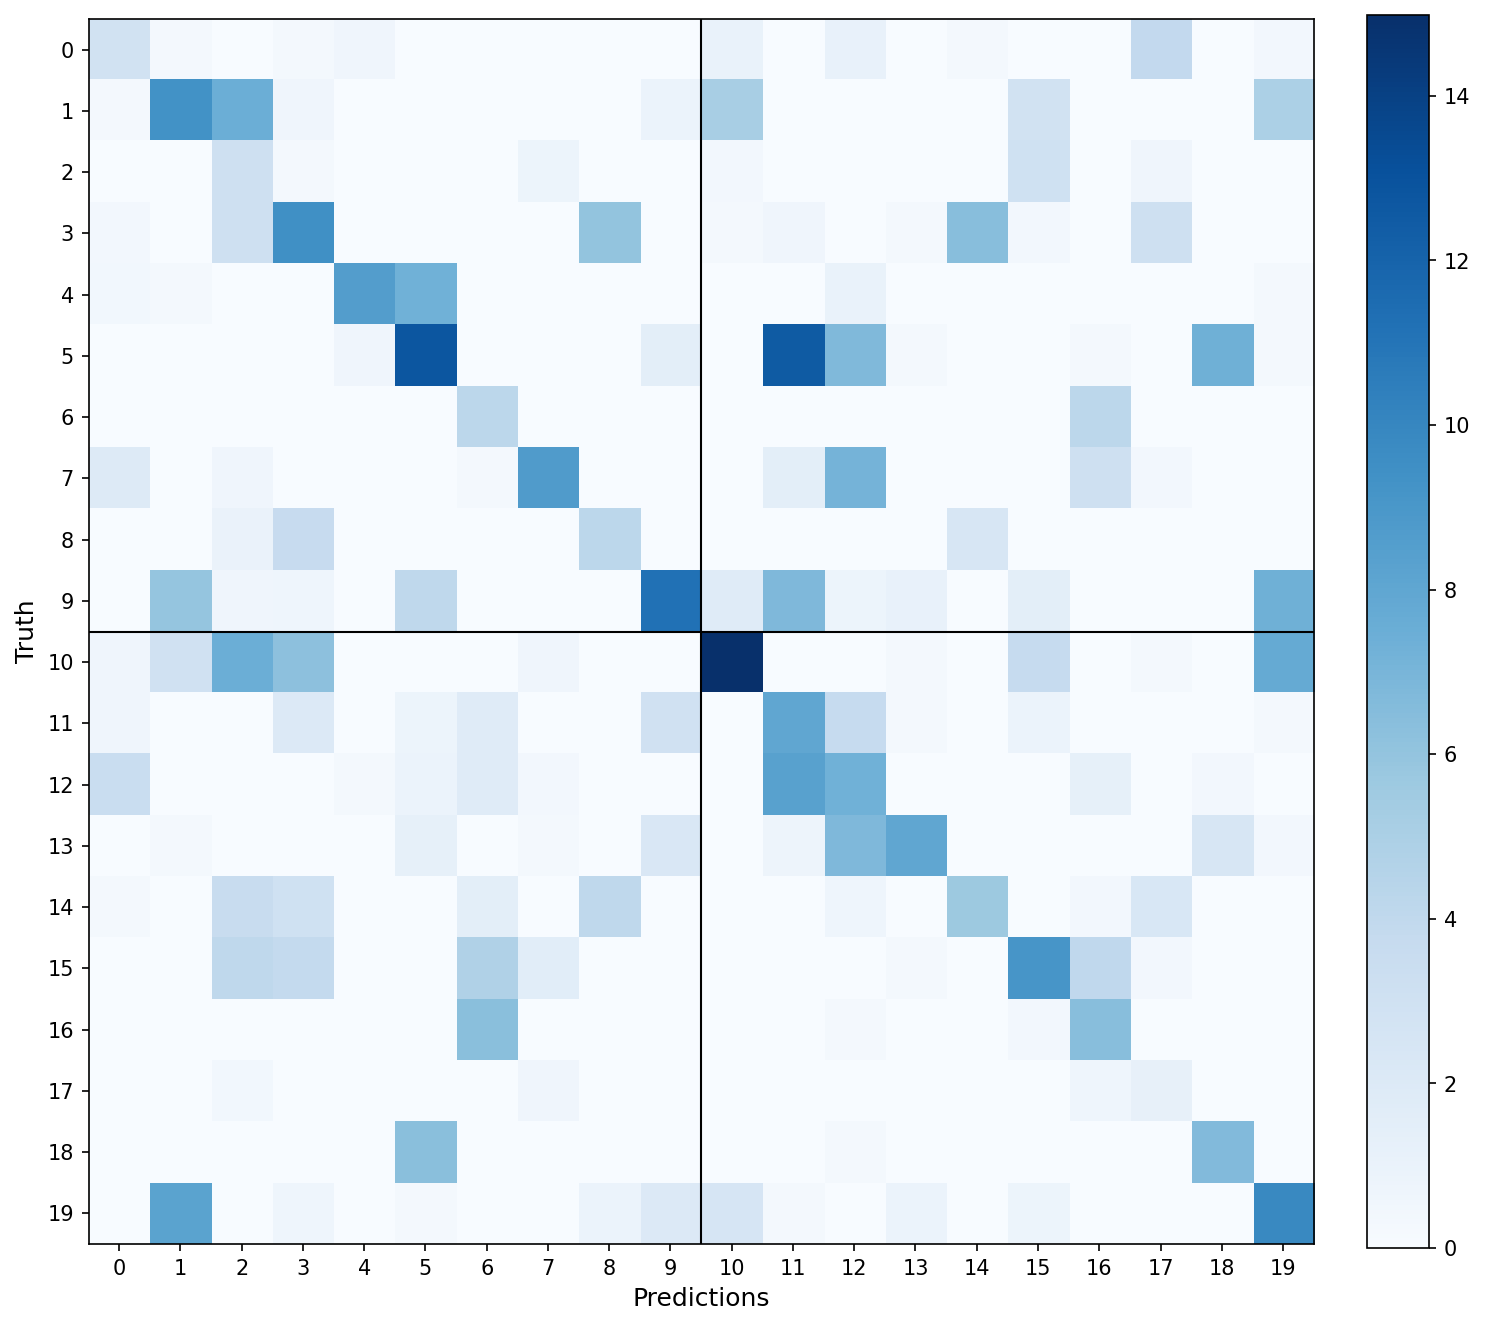

In [24]:
speakers = np.unique(z_train)
num_speakers = len(speakers)

cm_list = []
for i in range(num_speakers):
    preds = np.argmax(predict_test_list[i], axis=1)
    cm = confusion_matrix(y_test, preds)
    cm_list.append(cm)

cm_arr = np.stack(cm_list)  # shape: (10, 20, 20)

std_cm = cm_arr.std(axis=0)

plt.figure(figsize=(10, 10), dpi = 150)
plt.imshow(std_cm, cmap=plt.cm.Blues)
# plt.title("Std. Dev. of Confusion (Speaker Variability)", fontsize=16)
print("Standard dev across all confusion matrix generations")
mid = cm.shape[0] / 2
plt.axhline(mid - 0.5, linewidth=1, c = "k")
plt.axvline(mid - 0.5, linewidth=1, c = "k")
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.xticks(list(range(20)))
plt.yticks(list(range(20)))
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()